In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
from matplotlib.lines import Line2D

/usr/local/Cellar/python/3.7.2_2/Frameworks/Python.framework/Versions/3.7/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 192
  return f(*args, **kwds)
/usr/local/Cellar/python/3.7.2_2/Frameworks/Python.framework/Versions/3.7/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 192
  return f(*args, **kwds)
/usr/local/Cellar/python/3.7.2_2/Frameworks/Python.framework/Versions/3.7/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [6]:
data = pd.read_excel("data/Dog_Wolf.xls", delimiter="\t")

In [7]:
data.head()

,X1,X2,X3,X4,X5,X6,Вид
0,-2.778820,-2.830903,2.462796,-1.369489,-2.292341,-1.222118,1
1,-1.864175,-2.164261,0.379872,-0.406637,-0.070613,-0.125612,1
2,-1.278802,-1.297627,-0.168266,-1.215432,-1.477707,-0.369280,1
3,-0.620257,-0.830977,0.050990,-0.599207,-0.737131,-0.816005,1
4,-1.608074,-1.697612,-1.922307,-1.523545,-1.625823,-1.547009,1


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43 entries, 0 to 42
Data columns (total 7 columns):
X1     43 non-null float64
X2     43 non-null float64
X3     43 non-null float64
X4     43 non-null float64
X5     43 non-null float64
X6     43 non-null float64
Вид    43 non-null int64
dtypes: float64(6), int64(1)
memory usage: 2.4 KB


In [9]:
X_dogs = data[data['Вид'] == 1].values[:,:-1]
y_dogs = np.ones(data[data['Вид'] == 1].shape[0])
X_wolfs = data[data['Вид'] == 2].values[:,:-1]
y_wolfs = -1*np.ones(data[data['Вид'] == 2].shape[0])
x_uknown = data[data['Вид'] == 3].values[:,:-1][0]
y_ulnown = data[data['Вид'] == 3].values[:,-1][0]

In [10]:
X = np.vstack((X_dogs, X_wolfs))
y = np.concatenate((y_dogs, y_wolfs))

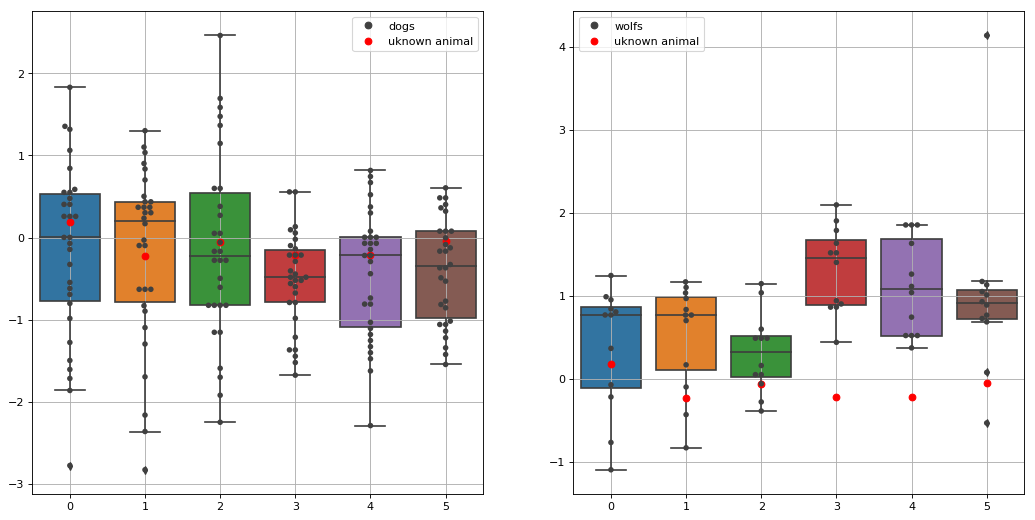

In [11]:
figure(num=None, figsize=(16, 8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot(121)
sns.boxplot(data=X_dogs,)
sns.swarmplot(data=X_dogs, color=".25",)
plt.plot(np.arange(X_dogs.shape[1]), x_uknown, 'ro', label="uknown animal")
plt.grid()
legend_elements = [Line2D([0], [0], marker='o',lw=0,color='.25', label='dogs'),
                   Line2D([0], [0],marker='o', lw=0,color='r', label='uknown animal')]
ax.legend(handles=legend_elements)
ax = plt.subplot(122)
sns.boxplot(data=X_wolfs)
sns.swarmplot(data=X_wolfs, color=".25",)
plt.plot(np.arange(X_dogs.shape[1]), x_uknown, 'ro',label="uknown animal")
legend_elements[0] = Line2D([0], [0], marker='o',lw=0,color='.25', label='wolfs')
plt.grid()
ax.legend(handles=legend_elements)

Чисто визуально наше неизвестное животное скорее относится к классу собак или является выбросом для волков. Покажем ээто при помощи статистики. Для этого воспользуемся логистической регрессией и посмотрим на веоятности принадлежности класса 3 волкам и собакам


In [12]:
class LogisticRgression:
    def __init__(self, numOfIter=1e4, step=1e-1, minDif=1e-3):
        self.numOfIter = int(numOfIter)
        self.step = step
        self.minDif = minDif
        self.wAll = []
    def __sigmoid(self, z):
        return 1 / (1 + np.exp(-z))
    def __addOnes(self, X):
        return np.concatenate((np.ones((X.shape[0],1)), X), axis=1)
    def __countLoss(self, X, y):
        return  np.log(1 + np.exp(-y*(X.dot(self.w)))).sum()
    def __getGradient(self, X,y):
        
        return np.sum([-y[i]*X[i,:] * val for i, val in enumerate(np.exp(-y * X.dot(self.w))/(1+ np.exp(-y * X.dot(self.w))))], axis=0)
    def fit(self,X,y):
        ## w - weights
        X = self.__addOnes(X)
        self.w = np.ones(X.shape[1])
        for i in range(self.numOfIter):
            grad  = self.__getGradient(X,y)
            if((grad**2).sum() < self.minDif):
                break
            self.w -= self.step  * grad
            self.wAll.append(self.w.copy())
            
            
    def predict_prob(self, X):
        X = self.__addOnes(X)
        return self.__sigmoid(np.dot(X, self.w))
    def predict(self, X):
        return 1 if self.predict_prob(X) >= 0.5 else -1

        

In [13]:
model = LogisticRgression()
model.fit(X,y)

In [14]:
model.predict_prob(x_uknown.reshape(1,-1))

array([0.99995827])

Видно что с вероятностью 99 процентов наша точка принадлежит классу собак, что означает что для класса волков это выброс.

Посмотрим на доверителтные интервалы для параметра $w$
Согласно статистики Вальда так как сы использовали метод максимального правдоподобия для вывода регрессии: $$W_j = \left(\frac{\hat{w}_i - w}{\hat{\sigma_\hat{w_i}}} \right)^2$$
$$ \hat{\sigma_\hat{w_i}} = \frac{1}{N-1}\sum_j (w_j - \overline{w_i})^2$$
распределено как $N(0,1)$. Отсюда находим границы интервала на каждую компоненнту
$$w_i \in \{\hat{w}_i - Z_{\frac{\alpha}{2}} \hat{\sigma_\hat{w_i}},  \hat{w}_i + Z_{\frac{\alpha}{2}} \hat{\sigma_\hat{w_i}} \}$$
$ Z_{\frac{\alpha}{2}}$ квантиль нормального распределения

In [15]:
W = np.array(model.wAll)
Z = 1.960
for i in range(W.shape[1]):
    sigma = np.sqrt(((W[:,i] - W[:,i].mean())**2).sum() /( W.shape[0] -1))
    print('w_%d - (%f, %f) Получен %f' %(i, W[:,i].mean() - Z*sigma, W[:,i].mean() + Z*sigma, model.w[i])) 


w_0 - (3.555372, 7.577171) Получен 6.755975
w_1 - (1.558310, 4.219786) Получен 3.669820
w_2 - (0.461245, 0.864868) Получен 0.733694
w_3 - (1.162379, 2.976948) Получен 2.590387
w_4 - (-12.039409, -4.683955) Получен -10.520203
w_5 - (-2.879043, -2.038679) Получен -2.714236
w_6 - (-3.095574, -1.803285) Получен -2.847825


Посмотрим какие признаки распределены нормально, для этого воспользуемся критерием $\chi^2 $. Введем следующие величины:
$$ n_j  - \text{количество наблюдений в j-м интервале}$$
$$p_j = F(b_j)-F(a_j) - \text{вероятность попадания наблюдения в j-ый интервал при выполнении гипотезы } H_0 $$
$$E_j = n_{p_j} - \text{ожидаемое число попаданий в j-ый интервал} $$

Тогда

$$Статистика: \chi^2 = \sum_{j=1}^k \frac{ \left( n_j-E_j \right)^2}{E_j} \sim \chi_{k-1}^2 - \text{Распределение хи-квадрат с k-1 степенью свободы. }$$

Мы можем оценить $n_j$ в предположении нормальности/

In [16]:
def count_chi(X):
    chi = []
    for i in range( X.shape[1]):
        interval = (X[:,i].max()-  X[:,i].min())/( X[:,i].shape[0])
        sigma_sq = ((X[:,i] -X[:,i].mean())**2).sum()/( X[:,i].shape[0] - 1)
        mu = X[:,i].mean()
        chi_count = 0
        k = int(X[:,i].shape[0])
        for j in range(k):
            x_l = X[:,i].min()+j*interval
            x_r =  X[:,i].min()+(j+1)*interval
            num_of_values = len(np.where((X[:,i] > x_l) * (X[:,i] <=x_r))[0])

            expected_num_of_values = k*1/(np.sqrt(2*np.pi*sigma_sq))* 1/2 * (np.exp(-1*(x_l - mu )**2/(2*sigma_sq)) + 
                                                                          np.exp(-1*(x_r - mu )**2/(2*sigma_sq))) * interval
            chi_count += (num_of_values - expected_num_of_values)**2 / expected_num_of_values
        chi.append(chi_count)
    return(chi)

In [17]:
## смотрим 90% квантиль 
quantile_dogs  = 19,768
quantile_wolf = 5,5778
quantile_whole = 29,907
print( "Dogs features " + str(count_chi(X_dogs)))
print( "Wolfs features " + str(count_chi(X_wolfs)))
print( "Whole features " + str(count_chi(X)))

Dogs features [18.995030913822248, 31.628827461952206, 24.76373702520164, 28.25643571323547, 20.461970399461517, 34.03980238450367]
Wolfs features [14.11889519387248, 14.983210114395067, 15.430803308067027, 15.004936695147014, 24.85034532460338, 36.200682155357526]
Whole features [34.40307461445303, 49.78779119295903, 34.77915084212773, 40.34244326387698, 55.62213013087728, 22.907485432350146]


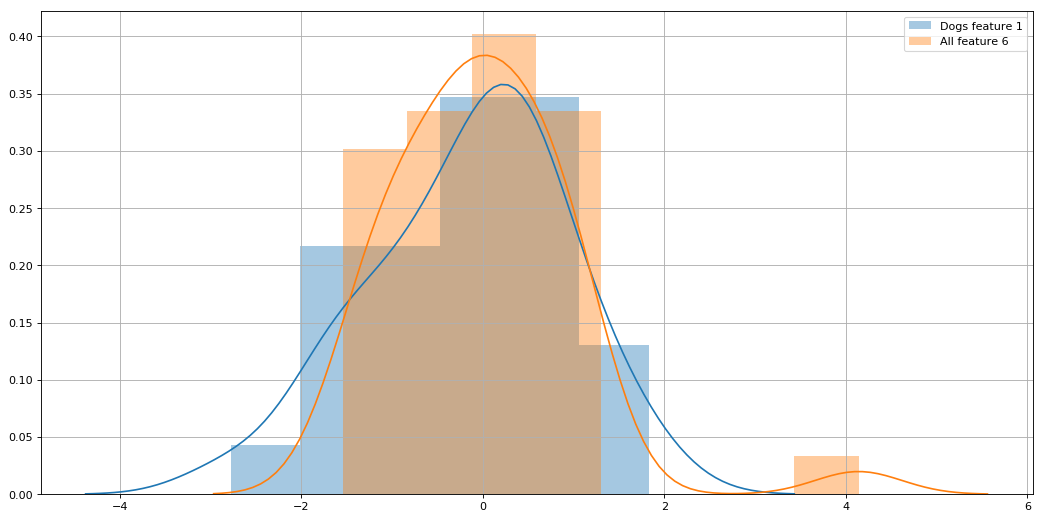

In [18]:
figure(num=None, figsize=(16, 8), dpi=80, facecolor='w', edgecolor='k')
sns.distplot(X_dogs[:,0], label="Dogs feature 1")
sns.distplot(X[:,-1], label = "All feature 6")
plt.legend()
plt.grid()

Посмотрим на корреляцию признаков 

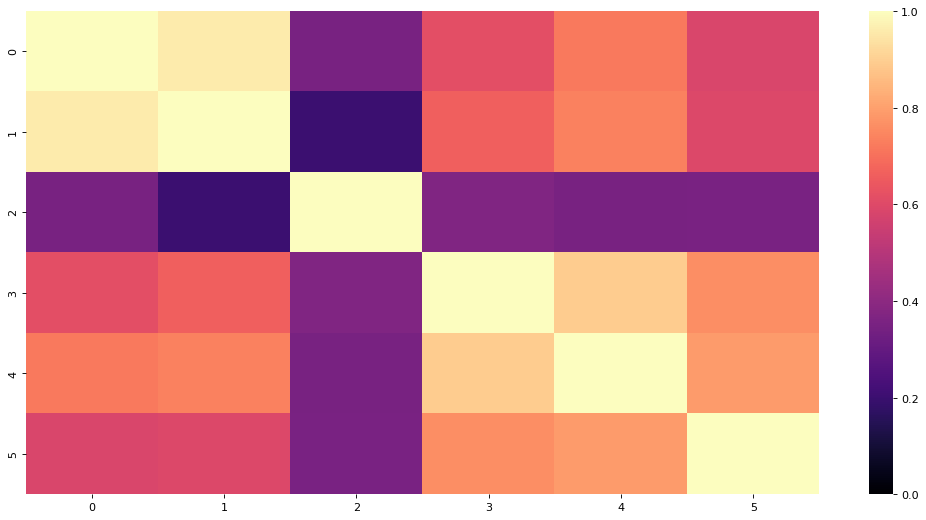

In [19]:
figure(num=None, figsize=(16, 8), dpi=80, facecolor='w', edgecolor='k')
sns.heatmap(np.corrcoef(X.T),cmap="magma",vmin=0, vmax=1)

Видно что - 0 и 1 первый признак довольно сильно коррелируют, также довольно высокая корреляция между 3 и 4 

Посчитаем коэффициент корреляции Кенделла
$$\tau=1-\frac{4}{n(n-1)}R, где R = \sum_{i=1}^{n-1}\sum_{j=i+1}^n\left[ \left[ x_i\ <\ x_j \right] \neq \left[ y_i\ <\ y_j \right] \right] $$

Рассмотрим  гипотезу $H_0$: Выборки x и y не коррелируют.
$$\tilde{\tau} = \frac{\tau}{\sqrt{D_{\tau}}}, \text{ где } D_{\tau}=\frac{2(2n+5)}{9n(n-1)}.$$
Нулевая гипотеза отвергается (против альтернативы $H_1$ - наличие корреляции), если:

$$ \left|\tilde{\tau}\right| \ge \Phi_{1-\alpha/2}$$
где $\Phi_{1-\alpha}$ есть $(1-\alpha)$-квантиль стандартного нормального распределения

In [20]:
def count_cor(X, k,l):
    n = X.shape[0]
    R = 0
    for i in range(n - 1):
        for j in range(i + 1, n):
            if ((X[i][k] < X[j][k]) != (X[i][l] < X[j][l])):
                R += 1
    t = 1- 4*R/ (n*(n-1))  
    D = 2*(2*n + 5)/(9*n*(n-1))
    return t, t/np.sqrt(D)
        

In [21]:
#z1–α/2 = 2,576 для α = 0,01
F_a = 2,576
correlation_matrix = np.zeros((X.shape[1], X.shape[1]))
importance_matrix = np.zeros((X.shape[1], X.shape[1]))
for i in range(correlation_matrix.shape[0]):
    for j in range(correlation_matrix.shape[0]):
        corr,importance = count_cor(X, i,j)
        correlation_matrix[i][j] = corr
        importance_matrix[i][j] = importance


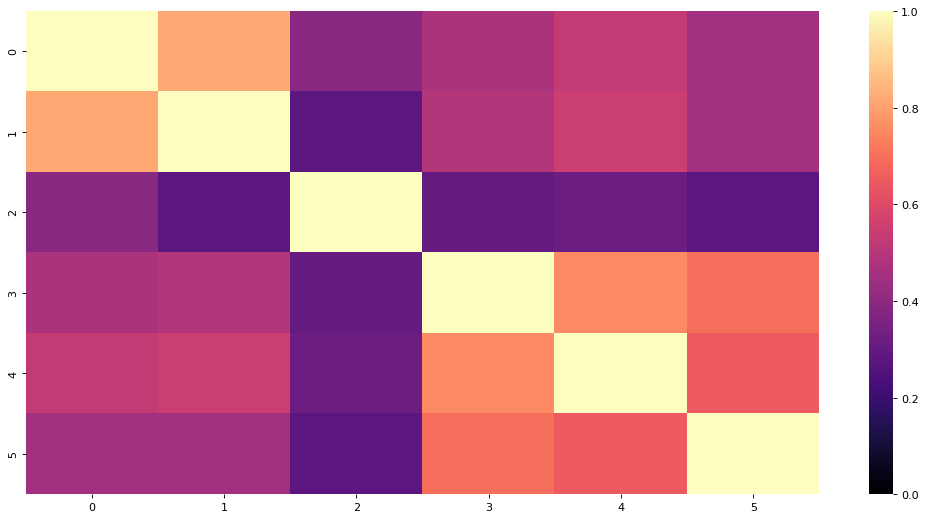

In [22]:
figure(num=None, figsize=(16, 8), dpi=80, facecolor='w', edgecolor='k')
sns.heatmap(correlation_matrix,cmap="magma",vmin=0, vmax=1)

In [23]:
importance_matrix

array([[9.33099222, 7.6186847 , 3.65220021, 4.43249224, 4.93101215,
        4.21574445],
       [7.6186847 , 9.33099222, 2.59013605, 4.62756525, 5.12608515,
        4.19406967],
       [3.65220021, 2.59013605, 9.33099222, 2.82855862, 2.98028207,
        2.61181083],
       [4.43249224, 4.62756525, 2.82855862, 9.33099222, 7.05514046,
        6.51327099],
       [4.93101215, 5.12608515, 2.98028207, 7.05514046, 9.33099222,
        6.05810064],
       [4.21574445, 4.19406967, 2.61181083, 6.51327099, 6.05810064,
        9.33099222]])

Видно что  все признаки относительно сильно коррелированы, согласно написанному выше